In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm
import numpy as np
from torch.utils.data import random_split

In [1]:
!pip install timm

     |████████████████████████████████| 431 kB 28.2 MB/s 


In [97]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    download = True,
    train = True,
    transform = transforms.Compose([
        transforms.Resize(73), 
        transforms.ToTensor(),
    ])
)
test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    download=True,
    train=False,
    transform = transforms.Compose([
        transforms.Resize(73), 
        transforms.ToTensor(),
    ])
)

In [98]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

In [99]:
from torch import nn
class Model(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(Model, self).__init__()

        self.model = timm.create_model('inception_v3', pretrained=False)

        self.model.Conv2d_1a_3x3.conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2)
    
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [100]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [101]:
model = Model()
model = model.to(device)

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 15

In [102]:
def train():
    loss = 0
    for j,(images,targets) in enumerate(tqdm(train_dataloader)):
        images, targets = images.to(device), targets.to(device)

        y_pred = model(images)

        loss = criterion(y_pred,targets.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in tqdm(test_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
    test_loss /= len(test_dataloader)
    return test_loss

In [103]:
losses_train = []
losses_test = []

for i in range(epochs):
    print(f"Epoch {i+1}")
    loss_train = train()
    losses_train.append(loss_train)
    loss_test = test()
    losses_test.append(loss_test)
    print(f"\nLoss train: {loss_train}, Loss test: {loss_test}")

Epoch 1


100%|██████████| 157/157 [00:04<00:00, 32.60it/s]



Loss train: 2.042484998703003, Loss test: 1.974338923290277
Epoch 2


100%|██████████| 157/157 [00:04<00:00, 32.33it/s]



Loss train: 0.9902964234352112, Loss test: 0.9031366432548329
Epoch 3


100%|██████████| 157/157 [00:04<00:00, 32.49it/s]



Loss train: 0.6219965219497681, Loss test: 0.6843499956996577
Epoch 4


100%|██████████| 157/157 [00:04<00:00, 32.42it/s]



Loss train: 0.6284598708152771, Loss test: 0.6349829177188265
Epoch 5


100%|██████████| 157/157 [00:04<00:00, 32.33it/s]



Loss train: 0.48168253898620605, Loss test: 0.5601218215599182
Epoch 6


100%|██████████| 157/157 [00:04<00:00, 32.33it/s]



Loss train: 0.4477018415927887, Loss test: 0.5435138088502701
Epoch 7


100%|██████████| 157/157 [00:04<00:00, 32.78it/s]



Loss train: 0.455840140581131, Loss test: 0.5100378507071999
Epoch 8


100%|██████████| 157/157 [00:04<00:00, 32.48it/s]



Loss train: 0.41695937514305115, Loss test: 0.47974417458294305
Epoch 9


100%|██████████| 157/157 [00:04<00:00, 32.55it/s]



Loss train: 0.5091037750244141, Loss test: 0.4587281962299043
Epoch 10


100%|██████████| 157/157 [00:04<00:00, 32.64it/s]



Loss train: 0.35317137837409973, Loss test: 0.45587194449962326
Epoch 11


100%|██████████| 157/157 [00:04<00:00, 32.33it/s]



Loss train: 0.32654595375061035, Loss test: 0.43993357421865886
Epoch 12


100%|██████████| 157/157 [00:04<00:00, 32.06it/s]



Loss train: 0.3579165041446686, Loss test: 0.412432426669795
Epoch 13


100%|██████████| 157/157 [00:04<00:00, 32.28it/s]



Loss train: 0.37420788407325745, Loss test: 0.45661970840138233
Epoch 14


100%|██████████| 157/157 [00:04<00:00, 32.43it/s]



Loss train: 0.3189981281757355, Loss test: 0.40435644348335875
Epoch 15


100%|██████████| 157/157 [00:04<00:00, 32.47it/s]


Loss train: 0.34369516372680664, Loss test: 0.3998193700032629


In [107]:
losses_train_ = [el.item() for el in losses_train]

Text(0, 0.5, 'loss')

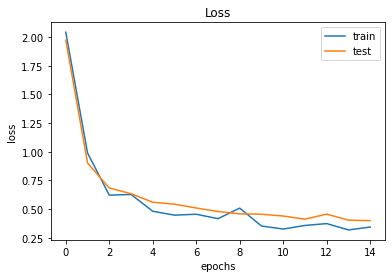

In [109]:
plt.title('Loss')
plt.plot(losses_train_, label = "train")
plt.plot(losses_test, label = "test")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [110]:
def predict(dataloader):
    pred_list = []

    for X, y in tqdm(dataloader):
        X = X.to(device)
        pred = model(X)
        pred = pred.detach().cpu()

        for i in range(len(y)):
            pred_list.append((pred[i], y[i]))
    
    return pred_list

In [111]:
x_test_features = predict(test_dataloader)

100%|██████████| 157/157 [00:05<00:00, 29.32it/s]


In [112]:
test_features = [el[0].numpy() for el in x_test_features]

In [113]:
label_test =  [el[1].item() for el in x_test_features]

In [114]:
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.587s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.305851
[t-SNE] Computed conditional probabilities in 0.372s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 73.4209290, gradient norm = 0.0028368 (50 iterations in 5.105s)
[t-SNE] Iteration 100: error = 73.9425278, gradient norm = 0.0005466 (50 iterations in 4.489s)
[t-SNE] Iteration 150: error = 74.0305786, gradient norm = 0.0003254 (50 iterations in 4.516s)
[t-SNE] Iteration 200: error = 74.0503159, gradient norm = 0.0003281 (50 iterations in 4.481s)
[t-SNE] Iteration 250: error = 74.0607910, gradient norm = 0.0002960 (50 iterations in 4.538s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.060791
[t-SNE] Iteration 300: error = 2.4525638, gradient norm = 0.0010035 (50 iterations in 4.529s)
[t-SNE] Iteration 350: error = 2.1951835, gradient norm = 0.0004682 (50 iterations in 4.527s)
[t-SNE] Iteration 400: error = 2.0574617, gradient norm = 0.0003067 (50 iterations in 4.403s)
[t-SNE] Iteration 450: error = 1.9575796, gradient norm = 0.0002255 (50 iterations in 4.416s)
[t-SNE] Iteration 500: error = 1.8817083, gradient norm = 0.0001718 (50 

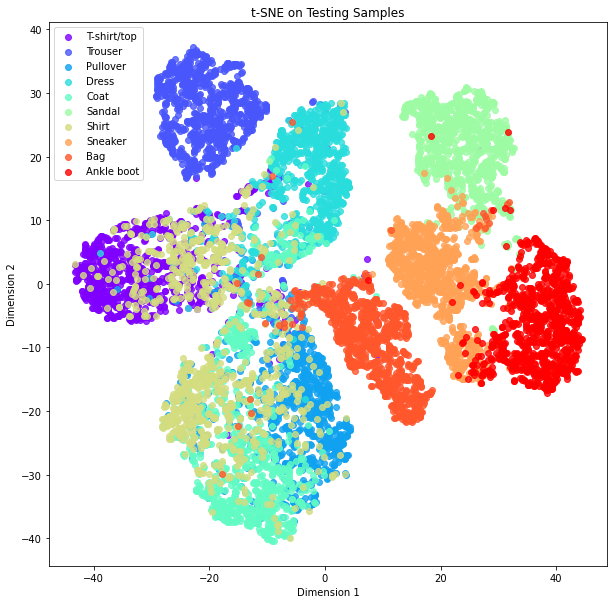

In [115]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(np.array(label_test)  == c_group), 0],
                tsne_features[np.where(np.array(label_test) == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)